# 📚 Final Project — Introduction to Deep Learning
## Image Classification with Convolutional Neural Networks (CNNs)

---

### 🔍 Overview
Design, train, and analyze **convolutional neural networks (CNNs)** for an image classification problem of your choice (the same one selected in Exercise 1). You previously built a dataset (~1,000 images) and trained a classifier using **fastai**. In this project, you will implement and train your own network in **PyTorch** (without fastai).

> **Focus is not only on accuracy.** Emphasize architectural choices, optimization strategies, hyperparameter tuning, overfitting vs generalization, and explaining *why* things worked or didn’t.

---

### 🎯 Learning Goals
- Design and train CNN architectures for image classification  
- Experiment with optimization algorithms and hyperparameters  
- Apply batch normalization and regularization techniques  
- Use transfer learning effectively  
- Work with pretrained networks (e.g., ResNet50)  
- Analyze and communicate experimental results clearly  

---

### 🧭 Project Structure (Summary)
- **Part 1 — Training a CNN from Scratch**  
  Build models, compare architectures/optimizers/hyperparameters; add batch norm & regularization; analyze overfitting vs generalization.
- **Part 2 — Transfer Learning**  
  Pretrain on an external dataset (e.g., CIFAR-10), then fine-tune on your dataset; compare with training from scratch.
- **Part 3 — Transfer learning with a Pretrained Network (ResNet50)**  
  Adapt ResNet50, replace the final layer, experiment with freezing/unfreezing and fine-tuning.

---

### 📦 Deliverables
- **Code:** All notebooks & scripts, clear structure/documentation, hosted in your **GitHub repo** from Exercise 1.  
- **Presentation (PPT):** Problem & dataset, experiments & results, comparisons & conclusions, final reflection.

---

### 🧪 Evaluation Criteria
- Experimental rigor  
- Quality of analysis  
- Clarity of explanations  
- Thoughtfulness of conclusions  
- Code organization & reproducibility  

*Accuracy alone is **not** the main criterion.*

---

### 📜 Academic Integrity
You may use external resources for reference, but:
- All work must be your own  
- You must understand and explain every line of code you submit  

---

## 📎 Appendix — Detailed Instructions (Click to expand)

<details>
  <summary><strong>Part 1 — Training a CNN from Scratch</strong></summary>

  ### Step 1 — Architecture & Optimization
  1. Choose <strong>at least two different CNN architectures</strong> (e.g., shallow vs deeper CNN).
  2. Compare <strong>optimization algorithms</strong> such as Adam and SGD with momentum.
  3. Tune key hyperparameters: <em>learning rate, batch size, number of epochs</em>.

  **Document every experiment clearly.** Explain:  
  - Why you chose each architecture  
  - How hyperparameters affected training  
  - What worked vs what didn’t  

  ### Step 2 — Add Batch Normalization
  Modify your best-performing architecture by adding <strong>Batch Normalization</strong> layers. Analyze:  
  - Training stability  
  - Convergence speed  
  - Validation performance  

  *Compare results with and without batch normalization.*

  ### Step 3 — Add Regularization
  Add <strong>regularization techniques</strong>:
  - Dropout  
  - Weight decay (L2 regularization)  
  - Data augmentation  

  Analyze:
  - Overfitting vs generalization  
  - Training vs validation curves  

  *Explain which regularization methods helped and why.*

  > Note: Depending on your dataset size and problem complexity, accuracy in Part 1 may be limited—you may need more data.
</details>

<details>
  <summary><strong>Part 2 — Transfer Learning</strong></summary>

  ### Step 4 — Pretraining on an External Dataset
  1. Choose an external image dataset (e.g., CIFAR-10 or another public dataset).  
  2. Train your CNN architecture on this dataset (or a subset if it’s too large).  
  3. Adjust your architecture as needed.  
  4. Save the trained weights.  

  *Explain why this dataset is relevant and what features it may teach the model.*

  ### Step 5 — Fine-Tuning on Your Dataset
  1. Load the pretrained weights.  
  2. Fine-tune the network using your dataset.  
  3. Compare results with training from scratch.  

  Analyze:
  - Speed of convergence  
  - Final accuracy  
  - Generalization  

  **Notes:**
  1. You may need to adjust image sizes/shapes to match your network’s expected input.  
  2. Adjust the final classification layer to the number of classes in the target dataset.
</details>

<details>
  <summary><strong>Part 3 — Transfer learning with a Pretrained Network (ResNet50)</strong></summary>

  ### Step 6 — Adapting a Pretrained Model
  1. Load <strong>ResNet50 pretrained on ImageNet</strong>.  
  2. Replace the final classification layer to match your number of classes.  
  3. Freeze and unfreeze layers as needed.  

  *Explain your design choices.*

  ### Step 7 — Training & Fine-Tuning
  1. Fine-tune the modified ResNet50 on your dataset.  
  2. Experiment with: freezing vs unfreezing layers, learning rates, and data augmentation.  

  Compare:
  - Performance vs your custom CNN  
  - Training time  
  - Stability  
</details>

<details>
  <summary><strong>Results & Analysis</strong></summary>

  Include:
  - Training & validation curves  
  - Quantitative metrics (accuracy, loss)  
  - Qualitative observations  
  - Short conclusions  

  **Focus on reasoning, not just numbers.**
</details>

<details>
  <summary><strong>Final Reflection</strong></summary>

  Reflect on:
  - What architectural choices mattered most?  
  - Which optimization strategies worked best?  
  - When did transfer learning help?  
  - What would you do differently with more time or data?  
</details>

<details>
  <summary><strong>What to Submit</strong></summary>

  - <strong>Code:</strong> All notebooks & scripts, clear structure & documentation, hosted in your <strong>GitHub repo</strong> from Exercise 1.  
  - <strong>Presentation (PPT):</strong> Problem & dataset, each experiment, results & comparisons, considerations & conclusions, final reflection.  

  *Explain your reasoning after every experiment.*
</details>

# Part 1 — Training a CNN from Scratch

In [2]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import numpy as np
import os



### Load data

In [123]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define transforms
base_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

aug_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [97]:
def get_loaders(data_root='./data', batch_size=16, train_split=0.8, use_augmentation=False):
    # Verify data directory exists
    if not os.path.exists(data_root):
        raise FileNotFoundError(f"Data directory '{data_root}' not found!")

    # Create two separate dataset instances with different transforms
    train_dataset = datasets.ImageFolder(root=data_root, transform=aug_transforms if use_augmentation else base_transforms)
    val_dataset = datasets.ImageFolder(root=data_root, transform=base_transforms)

    # Get total size and calculate split
    total_size = len(train_dataset)
    train_size = int(train_split * total_size)

    # Create indices for splitting
    indices = np.random.permutation(total_size)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    # Create subsets using the same indices for both datasets
    train_data = Subset(train_dataset, train_indices)
    val_data = Subset(val_dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

### Training setup

In [65]:
class CNNExperiment:
    def __init__(self, model, train_loader, val_loader, optimizer="Adam", momentum=0.9):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.momentum = momentum
        self.criterion = nn.CrossEntropyLoss()
        self.history = {'train_loss': [], 'val_acc': []}

    def train_epoch(self, optimizer):
        self.model.train()
        running_loss = 0.0
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        return running_loss / len(self.train_loader)

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

    def run(self, epochs, lr=1e-4):
        print(f"--------- start experiment with: epochs={epochs} | lr={lr} | batch_size={train_loader.batch_size}---------")
        optimizer = optim.Adam(self.model.parameters(), lr=lr) if self.optimizer == "Adam" else optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        for epoch in range(epochs):
            loss = self.train_epoch(optimizer)
            acc = self.evaluate()
            self.history['train_loss'].append(loss)
            self.history['val_acc'].append(acc)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Val Acc: {acc:.2f}%")



In [12]:
def plot_experiment_results(histories, titles):
    """
    histories: list of history dictionaries from CNNExperiment
    titles: list of strings describing each experiment
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for history, title in zip(histories, titles):
        ax1.plot(history['train_loss'], label=f'{title} (Loss)')
        ax2.plot(history['val_acc'], label=f'{title} (Acc)')

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.show()

## Step 1 - Architecture and optimization

### Shallow CNN

In [105]:
class ShallowCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(ShallowCNN, self).__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3x128x128 -> 16x64x64 after pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16x64x64 -> 32x32x32 after pooling
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32x32x32 -> 64x16x16 after pooling

        # Fully Connected Head
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#### Training & Fine-tuning

#### Experiment 1: LR fine-tuning
* We test three different lr in an exponential scale starting from 1e-3.
* Are goal in this level was to find highest LR that makes the training loss go down quickly without exploding.

--------- start experiment with: epochs=30 | lr=0.001 | batch_size=16---------
Epoch 1/30 - Loss: 1.6254, Val Acc: 41.67%
Epoch 2/30 - Loss: 0.7070, Val Acc: 73.15%
Epoch 3/30 - Loss: 0.4667, Val Acc: 79.63%
Epoch 4/30 - Loss: 0.3772, Val Acc: 69.44%
Epoch 5/30 - Loss: 0.3336, Val Acc: 75.00%
Epoch 6/30 - Loss: 0.2584, Val Acc: 79.63%
Epoch 7/30 - Loss: 0.1905, Val Acc: 77.78%
Epoch 8/30 - Loss: 0.1493, Val Acc: 74.07%
Epoch 9/30 - Loss: 0.1517, Val Acc: 75.93%
Epoch 10/30 - Loss: 0.0793, Val Acc: 73.15%
Epoch 11/30 - Loss: 0.0454, Val Acc: 78.70%
Epoch 12/30 - Loss: 0.0263, Val Acc: 79.63%
Epoch 13/30 - Loss: 0.0214, Val Acc: 80.56%
Epoch 14/30 - Loss: 0.0182, Val Acc: 75.93%
Epoch 15/30 - Loss: 0.0118, Val Acc: 78.70%
Epoch 16/30 - Loss: 0.0097, Val Acc: 79.63%
Epoch 17/30 - Loss: 0.0082, Val Acc: 79.63%
Epoch 18/30 - Loss: 0.0069, Val Acc: 78.70%
Epoch 19/30 - Loss: 0.0058, Val Acc: 79.63%
Epoch 20/30 - Loss: 0.0048, Val Acc: 78.70%
Epoch 21/30 - Loss: 0.0051, Val Acc: 77.78%
Epoch 

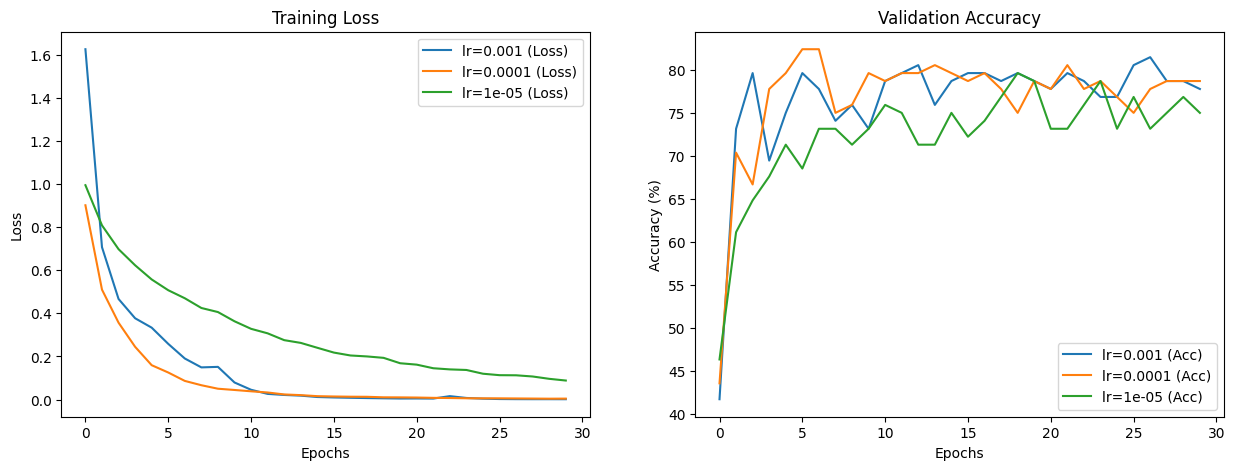

In [116]:
train_loader, val_loader = get_loaders()
LRs = [1e-3, 1e-4, 1e-5]
experiments = []

for lr in LRs:
    model = ShallowCNN()
    experiment = CNNExperiment(model, train_loader, val_loader)
    experiment.run(epochs=30, lr=lr)
    experiments.append(experiment)

plot_experiment_results([exp.history for exp in experiments], [f"lr={lr}" for lr in LRs])


### Experiment 2: Batch size fine tuning
* After choosing LR = 1e-4, our goal in this experiment was to find the best batch size which gives the fastest and smoothest convergence in training loss.

--------- start experiment with: epochs=30 | lr=0.0001 | batch_size=16---------
Epoch 1/30 - Loss: 0.9377, Val Acc: 58.33%
Epoch 2/30 - Loss: 0.5456, Val Acc: 68.52%
Epoch 3/30 - Loss: 0.4297, Val Acc: 68.52%
Epoch 4/30 - Loss: 0.2940, Val Acc: 71.30%
Epoch 5/30 - Loss: 0.2329, Val Acc: 71.30%
Epoch 6/30 - Loss: 0.1554, Val Acc: 72.22%
Epoch 7/30 - Loss: 0.1183, Val Acc: 70.37%
Epoch 8/30 - Loss: 0.0908, Val Acc: 69.44%
Epoch 9/30 - Loss: 0.0685, Val Acc: 70.37%
Epoch 10/30 - Loss: 0.0581, Val Acc: 70.37%
Epoch 11/30 - Loss: 0.0504, Val Acc: 70.37%
Epoch 12/30 - Loss: 0.0326, Val Acc: 71.30%
Epoch 13/30 - Loss: 0.0300, Val Acc: 72.22%
Epoch 14/30 - Loss: 0.0259, Val Acc: 73.15%
Epoch 15/30 - Loss: 0.0212, Val Acc: 73.15%
Epoch 16/30 - Loss: 0.0172, Val Acc: 72.22%
Epoch 17/30 - Loss: 0.0163, Val Acc: 73.15%
Epoch 18/30 - Loss: 0.0153, Val Acc: 72.22%
Epoch 19/30 - Loss: 0.0126, Val Acc: 72.22%
Epoch 20/30 - Loss: 0.0109, Val Acc: 69.44%
Epoch 21/30 - Loss: 0.0091, Val Acc: 70.37%
Epoch

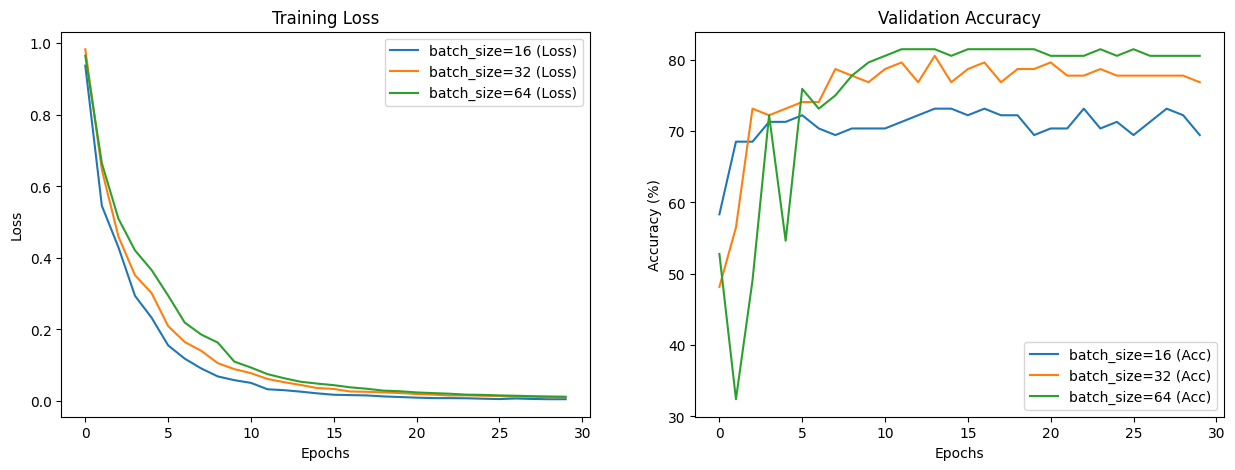

In [124]:
batch_sizes = [16, 32, 64]
experiments = []

for size in batch_sizes:
    train_loader, val_loader = get_loaders(batch_size=size)
    model = ShallowCNN()
    experiment = CNNExperiment(model, train_loader, val_loader)
    experiment.run(epochs=30, lr=1e-4)
    experiments.append(experiment)

plot_experiment_results([exp.history for exp in experiments], [f"batch_size={size}" for size in batch_sizes])

### Experiment 3: Optimizer fine tuning (Adam vs. SGD with momentum)

--------- start experiment with: epochs=30 | lr=0.0001 | batch_size=16---------
Epoch 1/30 - Loss: 0.9798, Val Acc: 63.89%
Epoch 2/30 - Loss: 0.5454, Val Acc: 72.22%
Epoch 3/30 - Loss: 0.4121, Val Acc: 69.44%
Epoch 4/30 - Loss: 0.2908, Val Acc: 78.70%
Epoch 5/30 - Loss: 0.1920, Val Acc: 63.89%
Epoch 6/30 - Loss: 0.2110, Val Acc: 80.56%
Epoch 7/30 - Loss: 0.1505, Val Acc: 75.93%
Epoch 8/30 - Loss: 0.0945, Val Acc: 76.85%
Epoch 9/30 - Loss: 0.0618, Val Acc: 78.70%
Epoch 10/30 - Loss: 0.0452, Val Acc: 81.48%
Epoch 11/30 - Loss: 0.0437, Val Acc: 81.48%
Epoch 12/30 - Loss: 0.0382, Val Acc: 74.07%
Epoch 13/30 - Loss: 0.0303, Val Acc: 78.70%
Epoch 14/30 - Loss: 0.0255, Val Acc: 81.48%
Epoch 15/30 - Loss: 0.0195, Val Acc: 78.70%
Epoch 16/30 - Loss: 0.0167, Val Acc: 80.56%
Epoch 17/30 - Loss: 0.0153, Val Acc: 76.85%
Epoch 18/30 - Loss: 0.0132, Val Acc: 82.41%
Epoch 19/30 - Loss: 0.0123, Val Acc: 80.56%
Epoch 20/30 - Loss: 0.0111, Val Acc: 78.70%
Epoch 21/30 - Loss: 0.0110, Val Acc: 79.63%
Epoch

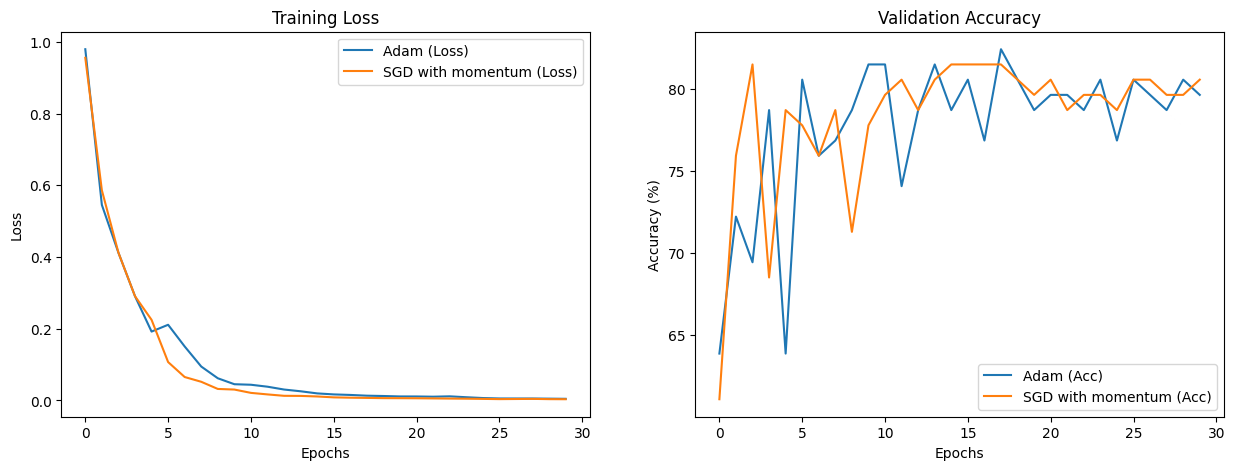

In [126]:
train_loader, val_loader = get_loaders()
experiments = []

model = ShallowCNN()
exp_with_adam = CNNExperiment(model, train_loader, val_loader)
exp_with_adam.run(epochs=30, lr=1e-4)
experiments.append(exp_with_adam)

model = ShallowCNN()
exp_with_sgd_momentum = CNNExperiment(model, train_loader, val_loader, optimizer="SGD", momentum=0.9)
exp_with_sgd_momentum.run(epochs=30, lr=1e-3)  # giving sgd a higher lr to move at a higher speed to fight Adam's speed.

plot_experiment_results([exp_with_adam.history, exp_with_sgd_momentum.history], [f"Adam", "SGD with momentum" ])

## Deep CNN

In [128]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define transforms
base_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

aug_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [130]:
import torch.nn.functional as F

class DeepCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(DeepCNN, self).__init__()

        # Convolutions layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3x256x256 -> 32x128x128 after pooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32x128x128 -> 64x64x64 after pooling
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 64x64x64 -> 128x32x32 after pooling
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 128x32x32 -> 256x16x16 after pooling
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # 256x16x16 -> 512x8x8 after pooling
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)  # 512x8x8 -> 1024x4x4 after pooling

        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected head
        self.fc1 = nn.Linear(1024 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))

        x = x.view(x.size(0), -1) # Flatten

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### Experiment 1: LR fine tuning
* We test three different lr in an exponential scale starting from 1e-3.
* Are goal in this level was to find highest LR that makes the training loss go down quickly without exploding.
* Compared to the ShallowCNN, the DeepCNN were more sensitive and converge slower so we gave it more epoches to learn.

--------- start experiment with: epochs=30 | lr=0.001 | batch_size=16---------
Epoch 1/30 - Loss: 1.0619, Val Acc: 51.85%
Epoch 2/30 - Loss: 0.9238, Val Acc: 53.70%
Epoch 3/30 - Loss: 0.8792, Val Acc: 62.04%
Epoch 4/30 - Loss: 0.8280, Val Acc: 61.11%
Epoch 5/30 - Loss: 0.7947, Val Acc: 64.81%
Epoch 6/30 - Loss: 0.6843, Val Acc: 70.37%
Epoch 7/30 - Loss: 0.6028, Val Acc: 66.67%
Epoch 8/30 - Loss: 0.4950, Val Acc: 70.37%
Epoch 9/30 - Loss: 0.4321, Val Acc: 71.30%
Epoch 10/30 - Loss: 0.3917, Val Acc: 69.44%
Epoch 11/30 - Loss: 0.3572, Val Acc: 72.22%
Epoch 12/30 - Loss: 0.1995, Val Acc: 74.07%
Epoch 13/30 - Loss: 0.1787, Val Acc: 74.07%
Epoch 14/30 - Loss: 0.2690, Val Acc: 74.07%
Epoch 15/30 - Loss: 0.1099, Val Acc: 74.07%
Epoch 16/30 - Loss: 0.0911, Val Acc: 71.30%
Epoch 17/30 - Loss: 0.1081, Val Acc: 72.22%
Epoch 18/30 - Loss: 0.1540, Val Acc: 69.44%
Epoch 19/30 - Loss: 0.0609, Val Acc: 73.15%
Epoch 20/30 - Loss: 0.0423, Val Acc: 71.30%
Epoch 21/30 - Loss: 0.0918, Val Acc: 73.15%
Epoch 

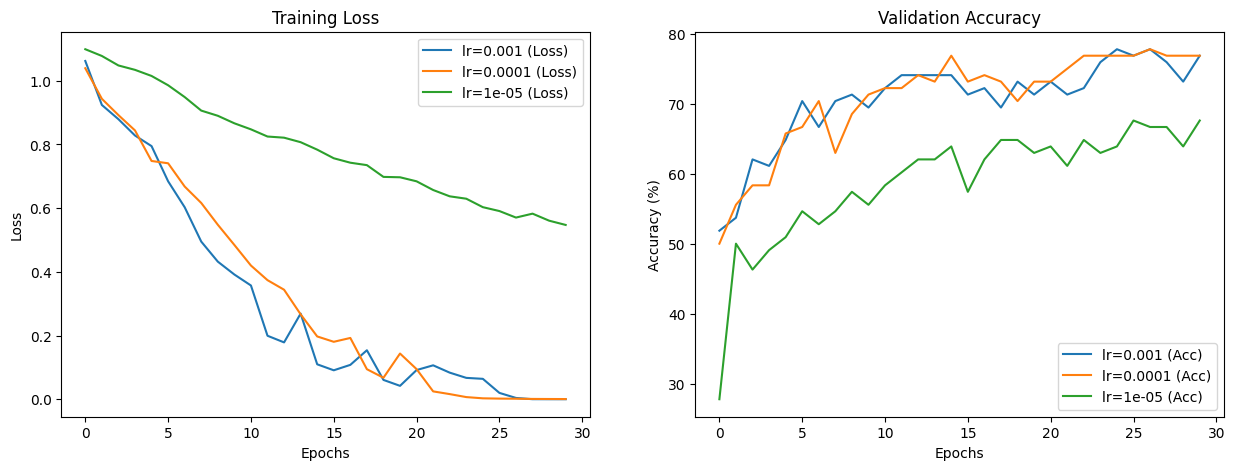

In [131]:
train_loader, val_loader = get_loaders()
LRs = [1e-3, 1e-4, 1e-5]
experiments = []

for lr in LRs:
    model = DeepCNN()
    experiment = CNNExperiment(model, train_loader, val_loader)
    experiment.run(epochs=30, lr=lr)
    experiments.append(experiment)

plot_experiment_results([exp.history for exp in experiments], [f"lr={lr}" for lr in LRs])

### Experiment 2: batch size fine-tuning
* After moving with LR = 1e-4, we want to optimize the batch size for it.
* Also, when we fine-tuned the ShallowNet, we realized that testing batch size if 64 is too high for our small dataset so we omitted it in this experiment.

--------- start experiment with: epochs=30 | lr=0.0001 | batch_size=16---------
Epoch 1/30 - Loss: 1.0683, Val Acc: 40.74%
Epoch 2/30 - Loss: 0.9803, Val Acc: 56.48%
Epoch 3/30 - Loss: 0.9166, Val Acc: 52.78%
Epoch 4/30 - Loss: 0.9174, Val Acc: 56.48%
Epoch 5/30 - Loss: 0.8367, Val Acc: 65.74%
Epoch 6/30 - Loss: 0.7780, Val Acc: 62.96%
Epoch 7/30 - Loss: 0.7211, Val Acc: 61.11%
Epoch 8/30 - Loss: 0.6425, Val Acc: 67.59%
Epoch 9/30 - Loss: 0.5991, Val Acc: 68.52%
Epoch 10/30 - Loss: 0.5360, Val Acc: 73.15%
Epoch 11/30 - Loss: 0.4949, Val Acc: 70.37%
Epoch 12/30 - Loss: 0.4688, Val Acc: 71.30%
Epoch 13/30 - Loss: 0.3862, Val Acc: 70.37%
Epoch 14/30 - Loss: 0.3382, Val Acc: 68.52%
Epoch 15/30 - Loss: 0.2774, Val Acc: 68.52%
Epoch 16/30 - Loss: 0.2535, Val Acc: 70.37%
Epoch 17/30 - Loss: 0.1725, Val Acc: 73.15%
Epoch 18/30 - Loss: 0.1169, Val Acc: 74.07%
Epoch 19/30 - Loss: 0.0827, Val Acc: 71.30%
Epoch 20/30 - Loss: 0.0831, Val Acc: 74.07%
Epoch 21/30 - Loss: 0.1081, Val Acc: 74.07%
Epoch

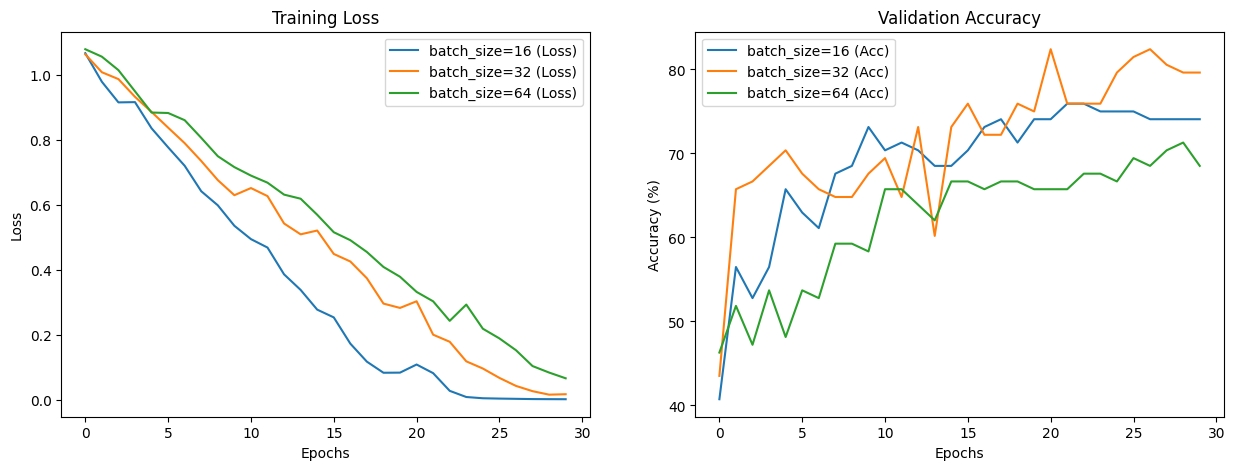

In [132]:
batch_sizes = [16, 32, 64]
experiments = []

for size in batch_sizes:
    train_loader, val_loader = get_loaders(batch_size=size)
    model = DeepCNN()
    experiment = CNNExperiment(model, train_loader, val_loader)
    experiment.run(epochs=30, lr=1e-4)
    experiments.append(experiment)

plot_experiment_results([exp.history for exp in experiments], [f"batch_size={size}" for size in batch_sizes])

## step 1 - Conclusions:
* Why we chose each architecture:
    * We wanted to compare a shallow CNN with lower image resolution (128x128) and only 3 convolution layers with a deep CNN with a high resolution (256x256) contains 6 convolution layers.
    * Originally, we hypothesized that deep networks with high resolution images will have more details to learn and it will leverage the network sensitivity to classify between delicate classes like sleeping fainting.
    * After we tested both networks, we got better training losses in much shorter training time with the shallow network. Despite having 1024 filters and high resolution input, the deep CNN performed worse. The 6-layer depth made backpropagation inefficient (vanishing gradients), and the high resolution added noise that the un-normalized network couldn't filter out efficiently.
    * The shallow CNN, with only 64 filters, proved that for small datasets, "keeping it simple" (lower resolution, fewer layers) often outperforms "going big" in the absence of advanced regularization.

* How hyperparameters effect training:
    * ShallowNet:
        * Thrived at lr=0.001 albeit was slightly more volatile in terms of training loss than 1e-4 and 1e-5 (which was underfitted)
        * Batch sizes 16 and 32 showed the same performance in terms of training loss convergence, while 32 were faster but more volatile. But, batch size 16 showed a smoother curve and also, as result of the no-normalization policy in step 1, we think that the extra noise which come with smaller batch size (e.g 16) might add an implicit regularization to the model.
        * Epoches fine-tuning in this phase was done on-the-go as we saw that our model start to converge to loss < 0.1 after epochs 23-25.
    * DeepNet:
        * Requirement for Lower Learning Rate: Due to its increased depth and complexity, the model required a smaller learning rate to converge effectively, finding its optimal stability an order of magnitude lower than the ShallowNet.
        * Convergence Speed vs. Precision Trade-off: While the higher learning rate (1e-3) yielded the fastest initial convergence (steepest drop in early epochs), it lacked the fine-grained control needed to settle into the global minimum, confirming that the slightly slower 1e-4 was necessary to achieve optimal precision without overshooting.
        * Balancing Noise and Stability: Given the small dataset (~1,000 items), batch_size=16 emerged as the optimal compromise. It mitigated the excessive stochastic noise observed at batch_size=8 (which can lead to erratic updates on small data) while avoiding the slow convergence of batch_size=32.
         * Linear Convergence: The choice favors the stability seen in the loss curve. With limited data, a smoother, more linear descent indicates a reliable learning process where the model captures true underlying patterns rather than overfitting to the noise of individual mini-batches.

Based on these experiments, we will proceed with the Shallow CNN trained on 128x128 images using Adam (lr=0.001, Batch Size=16).

## Step 2: applying batch normalization

In [113]:
class BnShallowCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(BnShallowCNN, self).__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3x128x128 -> 16x64x64 after pooling
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16x64x64 -> 32x32x32 after pooling
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32x32x32 -> 64x16x16 after pooling
        self.bn3 = nn.BatchNorm2d(64)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### experiment 1:  with vs without batch normalization

--------- start experiment with: epochs=30 | lr=0.001 | batch_size=16---------
Epoch 1/30 - Loss: 2.6305, Val Acc: 51.85%
Epoch 2/30 - Loss: 0.8437, Val Acc: 63.89%
Epoch 3/30 - Loss: 0.7272, Val Acc: 66.67%
Epoch 4/30 - Loss: 0.5608, Val Acc: 67.59%
Epoch 5/30 - Loss: 0.5520, Val Acc: 66.67%
Epoch 6/30 - Loss: 0.5648, Val Acc: 70.37%
Epoch 7/30 - Loss: 0.5643, Val Acc: 66.67%
Epoch 8/30 - Loss: 0.4271, Val Acc: 69.44%
Epoch 9/30 - Loss: 0.4638, Val Acc: 72.22%
Epoch 10/30 - Loss: 0.4025, Val Acc: 71.30%
Epoch 11/30 - Loss: 0.3596, Val Acc: 63.89%
Epoch 12/30 - Loss: 0.3706, Val Acc: 70.37%
Epoch 13/30 - Loss: 0.3395, Val Acc: 76.85%
Epoch 14/30 - Loss: 0.3382, Val Acc: 71.30%
Epoch 15/30 - Loss: 0.2938, Val Acc: 69.44%
Epoch 16/30 - Loss: 0.3208, Val Acc: 67.59%
Epoch 17/30 - Loss: 0.2603, Val Acc: 72.22%
Epoch 18/30 - Loss: 0.2017, Val Acc: 72.22%
Epoch 19/30 - Loss: 0.2222, Val Acc: 70.37%
Epoch 20/30 - Loss: 0.1619, Val Acc: 70.37%
Epoch 21/30 - Loss: 0.1899, Val Acc: 74.07%
Epoch 

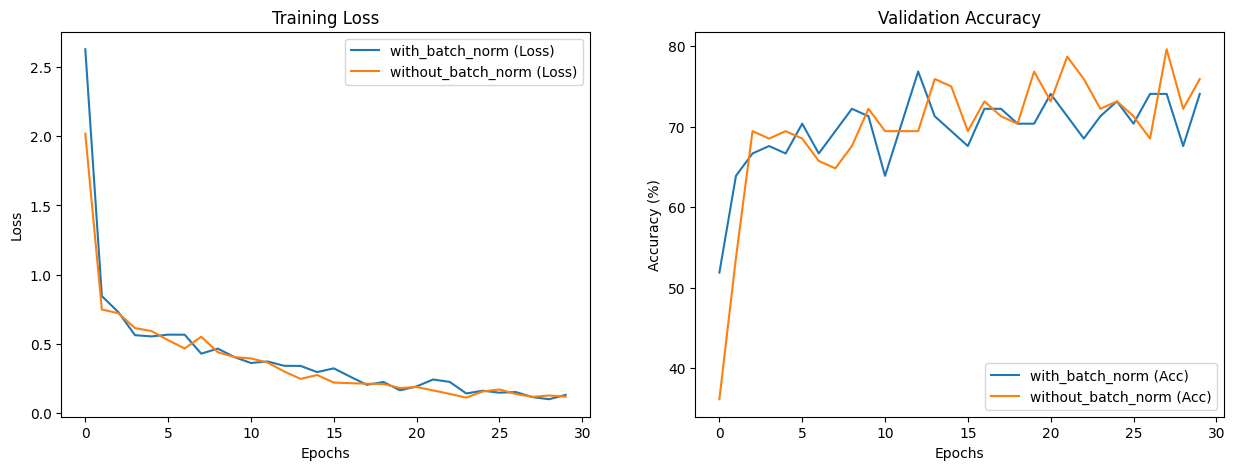

In [115]:
train_loader, val_loader = get_loaders(use_augmentation=True)

model = BnShallowCNN()
with_batch_norm_exp = CNNExperiment(model, train_loader, val_loader)
with_batch_norm_exp.run(epochs=30, lr=1e-3)

model = ShallowCNN()
without_batch_norm_exp = CNNExperiment(model, train_loader, val_loader)
without_batch_norm_exp.run(epochs=30, lr=1e-3)

plot_experiment_results([with_batch_norm_exp.history, without_batch_norm_exp.history], ["with_batch_norm", "without_batch_norm"])

# part 3 - Transfer learning with a Pretrained Network (ResNet50)

## Load data

In [ ]:
# # 1. Define your two sets of transforms
# base_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
#
# aug_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
#
# # 2. Helper to create loaders correctly (Avoids the Subset bug)
# def get_loaders(use_augmentation=False):
#     full_dataset = datasets.ImageFolder(root='./data')
#     train_size = int(0.8 * len(full_dataset))
#     val_size = len(full_dataset) - train_size
#     train_data, val_data = random_split(full_dataset, [train_size, val_size])
#
#     # Create separate dataset instances for different transforms
#     # or wrap them in a custom class to apply transforms independently
#     train_data.dataset.transform = aug_transforms if use_augmentation else base_transforms
#     val_data.dataset.transform = base_transforms
#
#     return DataLoader(train_data, batch_size=32, shuffle=True), DataLoader(val_data, batch_size=32)


In [8]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define transforms
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# aug_transforms = transforms.Compose([
#     transforms.Resize((256, 256)),  # Resize slightly larger first
#     transforms.RandomCrop(224),      # Then random crop to target size
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
aug_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize slightly larger first
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def get_loaders(data_root='./data', batch_size=32, train_split=0.8,
                use_augmentation=False, num_workers=4):

    # Verify data directory exists
    if not os.path.exists(data_root):
        raise FileNotFoundError(f"Data directory '{data_root}' not found!")

    # Create two separate dataset instances with different transforms
    train_dataset = datasets.ImageFolder(
        root=data_root,
        transform=aug_transforms if use_augmentation else base_transforms
    )

    val_dataset = datasets.ImageFolder(
        root=data_root,
        transform=base_transforms
    )

    # Get total size and calculate split
    total_size = len(train_dataset)
    train_size = int(train_split * total_size)

    # Create indices for splitting
    indices = np.random.permutation(total_size)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    # Create subsets using the same indices for both datasets
    train_data = Subset(train_dataset, train_indices)
    val_data = Subset(val_dataset, val_indices)

    # Create DataLoaders
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader

## Training setup:

In [4]:
def get_fresh_resnet():
    # Load clean weights from ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # Freeze all layers (Standard for Experiments 1 & 2)
    for param in model.parameters():
        param.requires_grad = False

    # Add your specific 3-class head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 3)
    )
    return model

In [5]:
class ResNetExperiment:
    def __init__(self, model, train_loader, val_loader):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = nn.CrossEntropyLoss()
        self.history = {'train_loss': [], 'val_acc': []}

    def train_epoch(self, optimizer):
        self.model.train()
        running_loss = 0.0
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        return running_loss / len(self.train_loader)

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

    def run(self, epochs, lr=1e-4, unfreeze_layer4=False):
        # Configure Optimizer based on unfreezing strategy
        if not unfreeze_layer4:
            print(f"--- Running Experiment: Frozen Backbone ---")
            optimizer = optim.Adam(self.model.fc.parameters(), lr=lr)
        else:
            print(f"--- Running Experiment: Unfrozen Layer 4 (Fine-tuning) ---")
            # Differential learning rates as discussed
            optimizer = optim.Adam([
                {'params': self.model.layer4.parameters(), 'lr': lr / 100},
                {'params': self.model.fc.parameters(), 'lr': lr}
            ])

        for epoch in range(epochs):
            loss = self.train_epoch(optimizer)
            acc = self.evaluate()
            self.history['train_loss'].append(loss)
            self.history['val_acc'].append(acc)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Val Acc: {acc:.2f}%")


In [6]:
def plot_experiment_results(histories, titles):
    """
    histories: list of history dictionaries from ResNetExperiment
    titles: list of strings describing each experiment
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for history, title in zip(histories, titles):
        ax1.plot(history['train_loss'], label=f'{title} (Loss)')
        ax2.plot(history['val_acc'], label=f'{title} (Acc)')

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.show()

# Training & Find tuning

## Experiment 1: Learning rate effect

In [ ]:
train_loader, val_loader = get_loaders()

# Configuration A: High LR
model = get_fresh_resnet()
exp_high_lr = ResNetExperiment(model, train_loader, val_loader)
exp_high_lr.run(epochs=10, lr=1e-3)

# Configuration A: Middle LR
model = get_fresh_resnet()
exp_middle_lr = ResNetExperiment(model, train_loader, val_loader)
exp_middle_lr.run(epochs=10, lr=1e-4)

# Configuration B: Low LR
model = get_fresh_resnet()
exp_low_lr = ResNetExperiment(model, train_loader, val_loader)
exp_low_lr.run(epochs=10, lr=1e-5)

plot_experiment_results(
    [exp_high_lr.history, exp_middle_lr.history, exp_low_lr.history],
    ['High LR (1e-3)','Middle LR (1e-4)', 'Low LR (1e-5)']
)

### Review another LR (5e-4) after analysis of the previous results
* We observed that aggressive LR of 1e-3 makes the optimizer taking steps that are slightly too large for the pre-trained weights, leading to a higher risk of instability during the later find-tuning phase (bouncing and oscillated loss).
* On the other hand, 1e-3 got the highest accuracy and the fastest convergence time compared to the other LRs.
* Therefor, we decided to conduct another test in that experiment to examine a high-middel LR between 1e-3 to 1e-4*

In [ ]:
model = get_fresh_resnet()
exp_high_medium_lr = ResNetExperiment(model, train_loader, val_loader)
exp_high_medium_lr.run(epochs=10, lr=5e-4)
plot_experiment_results(
    [exp_high_lr.history,exp_high_medium_lr.history, exp_middle_lr.history, exp_low_lr.history],
    ['High LR (1e-3)', "High-Medium LR (5e-4)" ,'Middle LR (1e-4)', 'Low LR (1e-5)']
)

## Experiment 2: Data augmentation effect

--- Running Experiment: Frozen Backbone ---
Epoch 1/10 - Loss: 0.7122, Val Acc: 85.19%
Epoch 2/10 - Loss: 0.2543, Val Acc: 91.67%
Epoch 3/10 - Loss: 0.1542, Val Acc: 92.59%
Epoch 4/10 - Loss: 0.0962, Val Acc: 93.52%
Epoch 5/10 - Loss: 0.0900, Val Acc: 94.44%
Epoch 6/10 - Loss: 0.0611, Val Acc: 94.44%
Epoch 7/10 - Loss: 0.0738, Val Acc: 93.52%
Epoch 8/10 - Loss: 0.0455, Val Acc: 95.37%
Epoch 9/10 - Loss: 0.0269, Val Acc: 95.37%
Epoch 10/10 - Loss: 0.0354, Val Acc: 94.44%
--- Running Experiment: Frozen Backbone ---
Epoch 1/10 - Loss: 0.7516, Val Acc: 88.89%
Epoch 2/10 - Loss: 0.3613, Val Acc: 93.52%
Epoch 3/10 - Loss: 0.1922, Val Acc: 93.52%
Epoch 4/10 - Loss: 0.1457, Val Acc: 92.59%
Epoch 5/10 - Loss: 0.1300, Val Acc: 91.67%
Epoch 6/10 - Loss: 0.0950, Val Acc: 92.59%
Epoch 7/10 - Loss: 0.0770, Val Acc: 92.59%
Epoch 8/10 - Loss: 0.0872, Val Acc: 92.59%
Epoch 9/10 - Loss: 0.0661, Val Acc: 91.67%
Epoch 10/10 - Loss: 0.0485, Val Acc: 92.59%


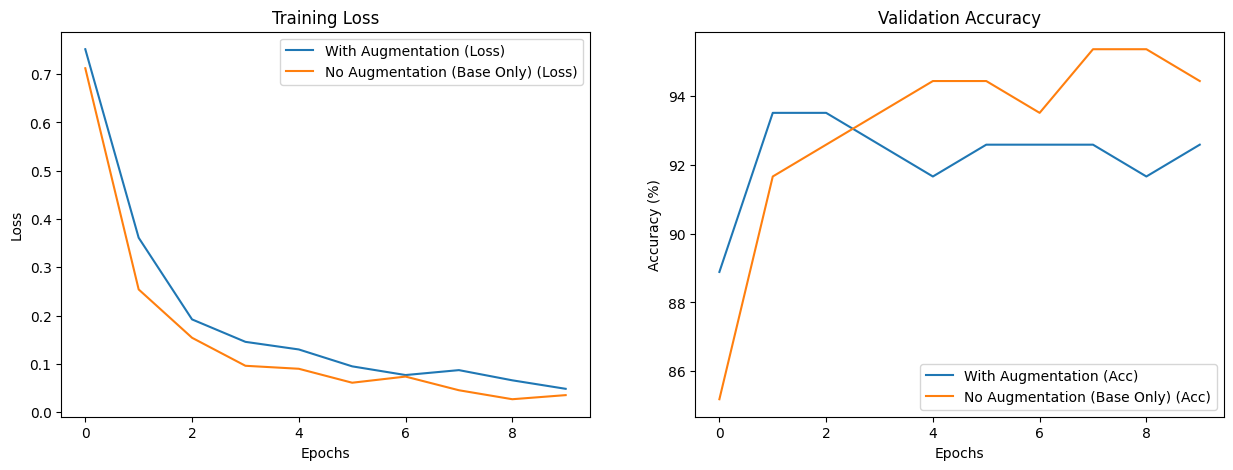

In [9]:
# No Augmentation
model_no_aug = get_fresh_resnet()
train_loader_no_aug, val_loader = get_loaders(use_augmentation=False)
exp_no_aug = ResNetExperiment(model_no_aug, train_loader_no_aug, val_loader)
exp_no_aug.run(epochs=10, lr=5e-4)

# With Augmentation
model_aug = get_fresh_resnet()
train_loader_aug, val_loader = get_loaders(use_augmentation=True)
exp_aug = ResNetExperiment(model_aug, train_loader_aug, val_loader)
exp_aug.run(epochs=10, lr=5e-4)

# Plot Comparison
plot_experiment_results(
    [exp_aug.history, exp_no_aug.history],
    ['With Augmentation', 'No Augmentation (Base Only)']
)

## Experiment 3: Freezing vs Unfreezing strategy

In [ ]:
# 1. Setup the data (using your best augmentation settings from Experiment 2)
train_loader, val_loader = get_loaders(use_augmentation=True)

# --- MODEL A: The "Long Frozen" Control (20 Epochs Frozen) ---
# This tests the maximum potential of just the head with more time.
print("\n--- Training Model A: 20 Epochs Frozen (Control) ---")
model_a = get_fresh_resnet()
exp_control = ResNetExperiment(model_a, train_loader, val_loader)
exp_control.run(epochs=20, lr=1e-4, unfreeze_layer4=False)

# --- MODEL B: The Fine-Tuning Strategy (10 Frozen + 10 Unfrozen) ---
# This tests the benefit of specializing the backbone.
print("\n--- Training Model B: Phase 1 (10 Epochs Frozen) ---")
model_b = get_fresh_resnet()
exp_b_phase1 = ResNetExperiment(model_b, train_loader, val_loader)
exp_b_phase1.run(epochs=10, lr=1e-4, unfreeze_layer4=False)

print("\n--- Training Model B: Phase 2 (10 Epochs Unfrozen/Fine-Tuning) ---")
# Unfreeze layer4 specifically for the second half
for param in model_b.layer4.parameters():
    param.requires_grad = True

exp_b_phase2 = ResNetExperiment(model_b, train_loader, val_loader)
exp_b_phase2.run(epochs=10, lr=1e-4, unfreeze_layer4=True)

# 2. Prepare combined history for Model B to plot it as a single 20-epoch line
model_b_full_history = {
    'train_loss': exp_b_phase1.history['train_loss'] + exp_b_phase2.history['train_loss'],
    'val_acc': exp_b_phase1.history['val_acc'] + exp_b_phase2.history['val_acc']
}

# 3. Plot the results
plot_experiment_results(
    [exp_control.history, model_b_full_history],
    ['Model A (20 Epochs Frozen)', 'Model B (10 Frozen + 10 Unfrozen)']
)